In [95]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [96]:
df = pd.read_csv('datasets/df.csv')
df['Date_Time_Event_Began'] = pd.to_datetime(df['Date_Time_Event_Began'],errors='coerce')
df['Date_Time_Restoration'] = pd.to_datetime(df['Date_Time_Restoration'],errors='coerce')
df.head()


,Month,Area_Affected,Event_Type,Demand_Loss_(MW),Number_of_Customers_Affected,Date_Time_Event_Began,Date_Time_Restoration,Event_Duration_(hours),Year
0,January,Washington,System Operations,0.0,NaN,2019-01-05 13:19:00,2019-01-05 15:07:00,1.80,2019
1,January,Washington,Severe Weather,230.0,230000.0,2019-01-06 03:00:00,2019-01-09 07:00:00,76.00,2019
2,January,California,Severe Weather,300.0,90382.0,2019-01-06 17:56:00,2019-01-06 21:52:00,3.93,2019
3,January,Washington,Severe Weather,NaN,230000.0,2019-01-06 01:00:00,2019-01-06 12:00:00,11.00,2019
4,January,Michigan,System Operations,0.0,0.0,2019-01-07 20:57:00,2019-01-07 21:32:00,0.58,2019


### Initial Analysis

In [97]:
# basic statistics
df[['Demand_Loss_(MW)','Number_of_Customers_Affected','Event_Duration_(hours)']].describe()

,Demand_Loss_(MW),Number_of_Customers_Affected,Event_Duration_(hours)
count,1016.000000,1.241000e+03,1232.000000
mean,422.814961,5.654928e+04,16.446144
std,4456.254202,1.651757e+05,33.435344
min,0.000000,0.000000e+00,0.020000
25%,0.000000,0.000000e+00,0.670000
50%,0.000000,0.000000e+00,3.200000
75%,32.500000,6.000000e+04,15.030000
max,133200.000000,2.000000e+06,328.920000


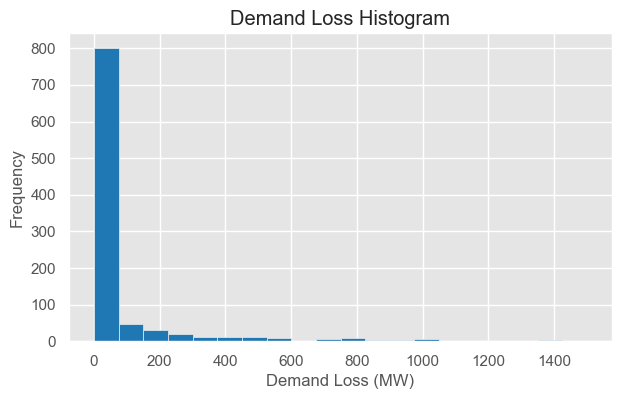

In [98]:
ax = df.loc[df['Demand_Loss_(MW)']<=1500,'Demand_Loss_(MW)'].plot(kind='hist',
                            bins=20,
                            figsize=(7,4),
                            color='tab:blue',
                            title='Demand Loss Histogram')
ax.set_xlabel('Demand Loss (MW)')
plt.show()

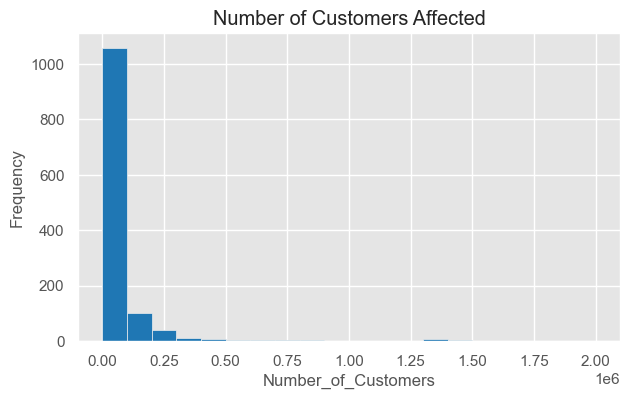

In [99]:
ax = df['Number_of_Customers_Affected'].plot(kind='hist',
                                             bins=20,
                                             color='tab:blue',
                                             title='Number of Customers Affected',
                                             figsize=(7,4))
ax.set_xlabel('Number_of_Customers')
plt.show()

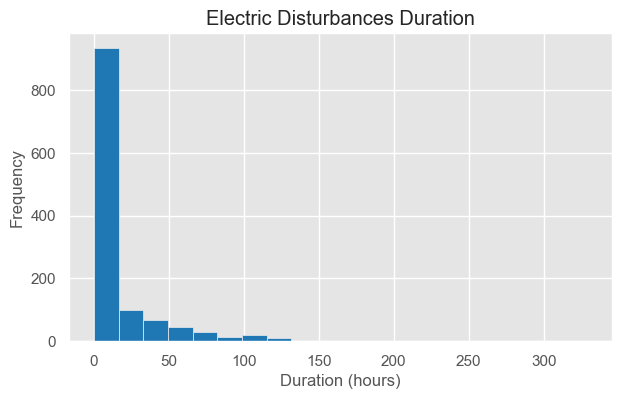

In [100]:
ax = df['Event_Duration_(hours)'].plot(kind='hist',
                                       figsize=(7,4),
                                       color='tab:blue',
                                       bins=20,
                                       title='Electric Disturbances Duration')
ax.set_xlabel('Duration (hours)')
plt.show()

 - Half of the electric disturbances did not affected customers or caused demand loss.
 - Over the past four years, an average of approximately 56,000 customers have experienced electric disturbance.
 - Half of the electric disturbances last less than 3 hours.
 - 25% of electric disturbances in the last four years have lasted more than 14 hours.  

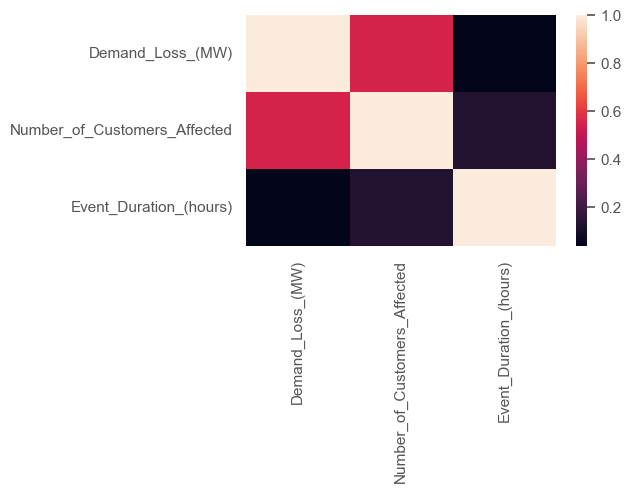

In [101]:
df_corr = df[['Demand_Loss_(MW)','Number_of_Customers_Affected','Event_Duration_(hours)']].dropna().corr()

fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_corr)
plt.show()

- The number of customers affected and the loss of demand are weakly correlated.
- The duration of the event has a small effect on the number of affected customers and the loss of demand.
- Note: This analysis is only valid for linear correlations.

#

## Questions

### How many electric disturbances occurred in the U.S. from 2019 to 2022?

In [102]:
print(f'{df.shape[0]} events were recorded.')

1426 events were recorded.


### What is the number of events per year?

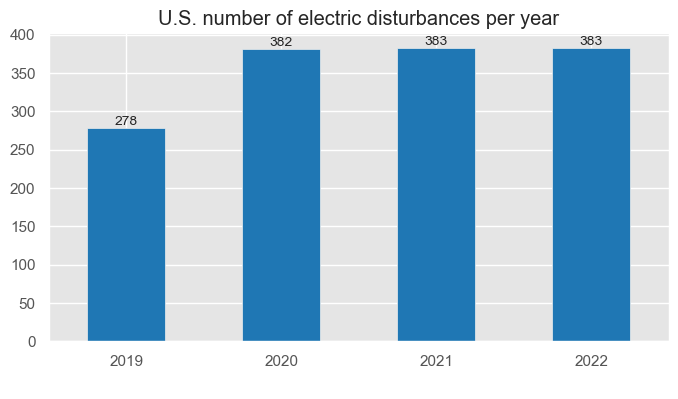

In [103]:
#fig, ax = plt.subplots(figsize=(5,3))

ax = df.groupby('Year')['Area_Affected'] \
      .agg('count')\
      .plot(kind='bar',
            title='U.S. number of electric disturbances per year',
            rot=0,
            color='tab:blue',
            figsize=(8,4))

ax.set_xlabel(' ')
ax.bar_label(ax.containers[0])
plt.show()

- In the last three years the number of electric disturbances are quite close.
- It is important to remember that in 2020 and 2021 occurred severe blackouts, which did not happen in 2022.

#


### What is the number of electric disturbances by month each year?

In [104]:
#aggregating the number of events by year and month
df_plotly = df.groupby(['Year','Month'], sort=False, as_index=False)['Area_Affected'] \
                .agg('count') \
                .rename(columns={'Area_Affected':'Number_of_Events'})

#creating a new column concatenating months and years
df_plotly['Month_Year'] = df_plotly['Month'] \
                              +' '+df_plotly['Year'].apply(str)
#ploting
fig = px.line(df_plotly, 
              x='Month_Year', 
              y='Number_of_Events',
              title='U.S. monthly number of electric disturbances: 2019-2022',
              labels={
                     'Number_of_Events': 'Number of Events ',
                     'Month_Year': ' '
                        },
              markers=True          
            )

#setting the x tick labels
fig.update_xaxes(ticktext=['Jan 2019','Jan 2020','Jan 2021','Jan 2022'],
                 tickvals=['January 2019','January 2020','January 2021','January 2022'])
fig.show()                          


- The two largest numbers of events (August 2020 and February 2021) were caused by blackouts in California and Texas, respectively.
- In 2021 and 2022, the number of disturbances increases as summer approaches and tends to decrease in the fall.



# 

### What is the number of disturbances by season each year?

In [105]:
#Spring - March to May.
#Summer - June to August.
#Autumn - September to November.
#Winter - December to February.

#creating a temporary dataframe
df_temp_season = df.copy()

# categorizing every month according to its season
cat_mapping = {
    'March':'Spring',
    'April':'Spring',
    'May':'Spring',
    'June':'Summer',
    'July':'Summer',
    'August':'Summer',
    'September':'Fall',
    'October':'Fall',
    'November':'Fall',
    'December':'Winter',
    'January':'Winter',
    'February':'Winter'
}

# creting a column 'Season'
df_temp_season['Season'] = df_temp_season['Month'].map(cat_mapping)

# grouping by year/season and counting the number of events using the 'Area_Affected' column
df_temp_season = df_temp_season.groupby(['Year','Season'], as_index=False)['Area_Affected'] \
                               .agg('count')

# stacked bar plot 
fig = px.bar(df_temp_season,
             x='Year',
             y='Area_Affected',
             color='Season',
             title='U.S. number of electric disturbances by season',
             width=700,
             height=500,
             labels={
                 'Year' : ' ',
                 'Area_Affected': 'Number of events'}
             )
fig.show()


- In the last four years, summer season had more disturbances in three years.
- From 2019 to 2022, the number of electric disturbances in the fall season are similar.  

In [ ]:
# https://realpython.com/pandas-groupby/
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
# https://www.datacamp.com/tutorial/python-seaborn-line-plot-tutorial


### What is the number of events by U.S. state?

In [106]:
# list with all the US states
us_states_list = ['Alabama','Alaska', 'Arizona', 'Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

# list with US states abbreviation
us_stat_abbr_list = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO',
'MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

cat_mapping = {us_states_list[i] : us_stat_abbr_list[i] for i in range(len(us_states_list))}

# list with the number of events 
num_events_by_state = [sum(df['Area_Affected'].str.contains(i)) for i in us_states_list]

# ploting the US map with the number of electric disturbances by state
fig = px.choropleth(locations=us_stat_abbr_list,
                    locationmode='USA-states',
                    color=num_events_by_state,
                    labels={'color': 'Number of events'},
                    color_continuous_scale='Blues',
                    scope='usa',
                    height=400,
                    width=700)
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    title_text = '2019-2022 U.S. number of electric disturbances by state')
fig.show()

### Which states registered more disturbance events from 2019-2022?

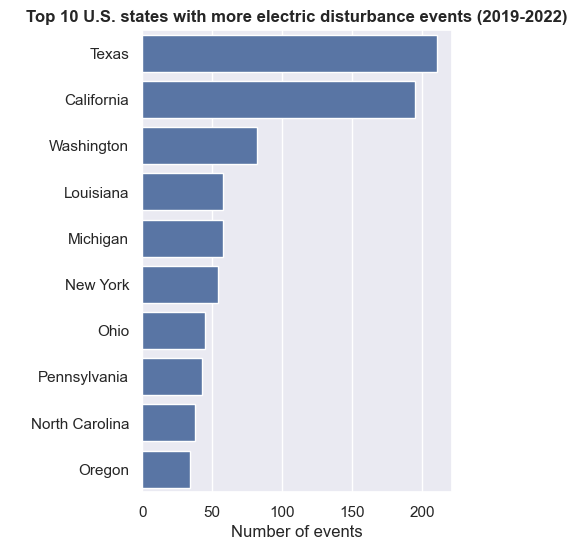

In [107]:
# dataframe with the number of electric events by US state
df_states_events = pd.DataFrame({'State':us_states_list, 'Number_of_events':num_events_by_state})

df_states_events = df_states_events.sort_values('Number_of_events',ascending=False).head(10)

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(4,6))

sns.barplot(data=df_states_events,
            x='Number_of_events',
            y='State',
            color='b') \
            .set_title('Top 10 U.S. states with more electric disturbance events (2019-2022)', 
                       fontdict = {'fontsize':12,
                                   'fontweight':'bold'})

ax.set_ylabel(' ')
ax.set_xlabel('Number of events')
plt.show()


In [ ]:
#https://www.geeksforgeeks.org/choropleth-maps-using-plotly-in-python/
#https://www.geeksforgeeks.org/how-to-make-a-choropleth-map-with-a-slider-using-plotly-in-python/

### Which period of the day experiences the most electric disturbances?

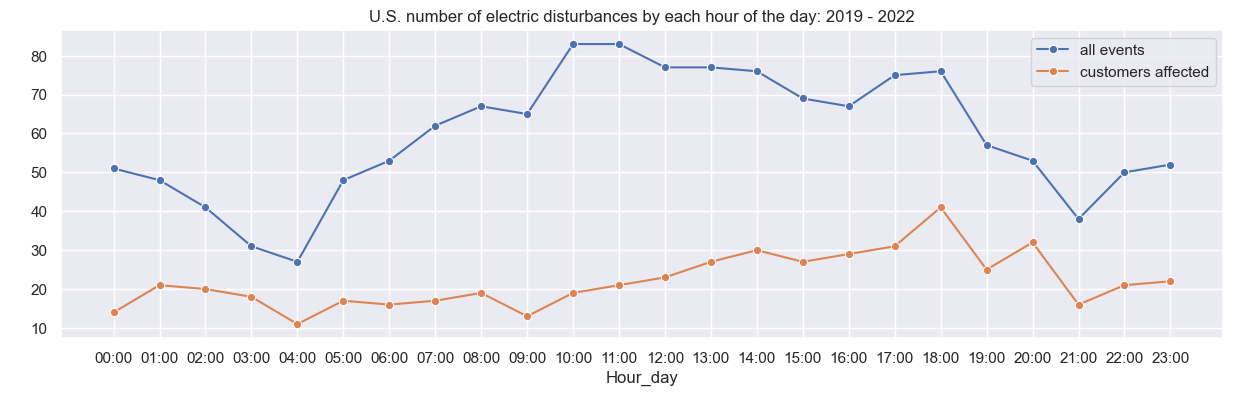

In [108]:
# list with the hour of the day
hour_day = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']
df_events_hour1 = df.copy()

# adding the 'hour' column to the dataset
df_events_hour1['Hour'] = [x.hour for x in df_events_hour1['Date_Time_Event_Began']]

# aggregating by hour and counting the number of events 
df_events_hour = df_events_hour1.groupby('Hour', as_index=False)['Area_Affected'] \
                                 .agg('count') \
                                 .rename(columns={'Area_Affected':'Number_of_events'})

df_events_hour_CA = df_events_hour1.loc[df_events_hour1['Number_of_Customers_Affected']>0].groupby('Hour', as_index=False)['Area_Affected'] \
                                                     .agg('count')
                                 
df_events_hour['Number_of_events_CA'] = df_events_hour_CA['Area_Affected'].values
df_events_hour['Hour_day'] = hour_day

#plotting
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(style='darkgrid')
sns.lineplot(data=df_events_hour,
             x='Hour_day', 
             y='Number_of_events',            
             marker='o').set(title='U.S. number of electric disturbances by each hour of the day: 2019 - 2022') 

sns.lineplot(data=df_events_hour,
             x='Hour_day', 
             y='Number_of_events_CA',            
             marker='o') 

plt.legend(labels=['all events','customers affected']) 
ax.set_ylabel(' ')
plt.show()

- Considering all events, the period of the day with the highest electric disturbances occurs between 11 am and 12 am.
- However, when taking only the events which affected customers, the period occurs between 18 pm and 19 pm.

# 

### What are the most common types of events?

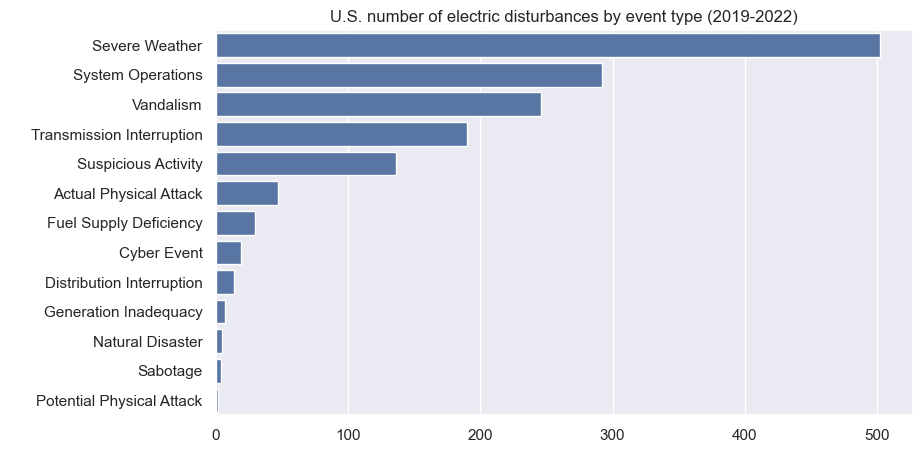

In [109]:
# selecting the unique events
unique_events = pd.DataFrame({'Event':df['Event_Type'].unique()})                    
unique_events = unique_events.loc[~unique_events['Event'].str.contains('/')]

# counting the number of events by type
count_event_type = [sum(df['Event_Type'].str.count(x)) for x in unique_events['Event']]

#count_event_type = [sum(df.loc[df['Number_of_Customers_Affected'] > 0,'Event_Type']\
#                        .str.count(x)) for x in unique_events['Event']]


df_event_type = pd.DataFrame({'Event_Type':unique_events['Event'],'Number_of_occurences':count_event_type})
df_event_type = df_event_type.sort_values('Number_of_occurences',ascending=False)

#plotting
fig,ax = plt.subplots(figsize=(9,5))
sns.set_theme(style ='darkgrid')
sns.barplot(data=df_event_type, x='Number_of_occurences', y='Event_Type', color='b')\
    .set(title='U.S. number of electric disturbances by event type (2019-2022)')
ax.set_ylabel(' ')
ax.set_xlabel(' ')
plt.show()

- Severe weather, system operations and vandalism are the most commom events type.


#

### Which event types caused more Demand loss?

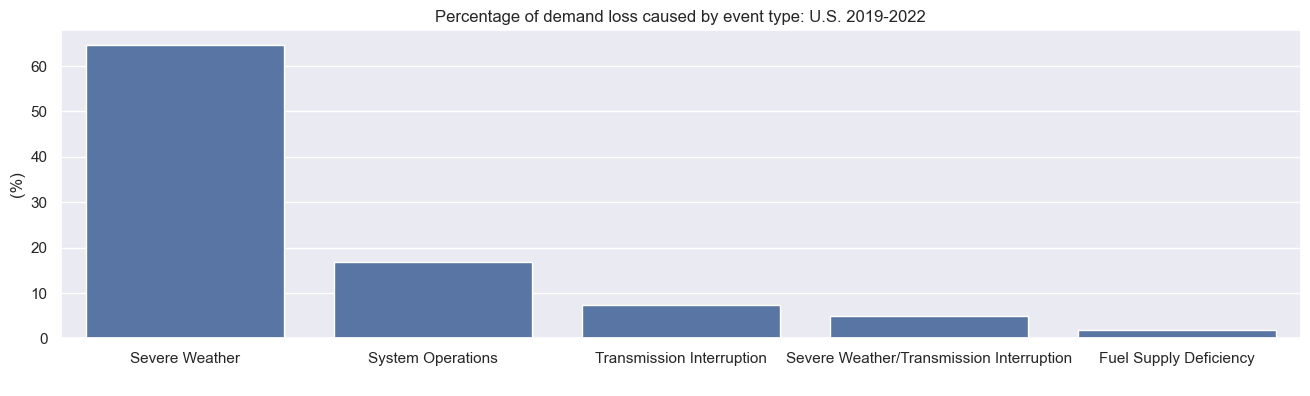

In [110]:
df_events_type_loss = df.groupby('Event_Type', as_index=False)['Demand_Loss_(MW)']\
                   .agg('sum')\
                   .sort_values('Demand_Loss_(MW)', ascending=False)


df_events_type_loss['Percentage_(%)'] = round((df_events_type_loss['Demand_Loss_(MW)']/sum(df_events_type_loss['Demand_Loss_(MW)']))*100,2)

fig,ax = plt.subplots(figsize=(16,4))
sns.set_theme(style='darkgrid')
sns.barplot(data=df_events_type_loss.head(5),
            y='Percentage_(%)',
            x='Event_Type',
            color='b')\
            .set(title='Percentage of demand loss caused by event type: U.S. 2019-2022')

ax.set_xlabel(' ')
ax.set_ylabel('(%)')
plt.show()


- Severe weather, system operations and transmission interruptions were responsible for the largest share of lost demand.
- Although vandalism, suspicious activity, and actual physical attacks are more frequent events, they have little impact on demand loss.

#

### What is the number of customers affected by each year?

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8420\113160536.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



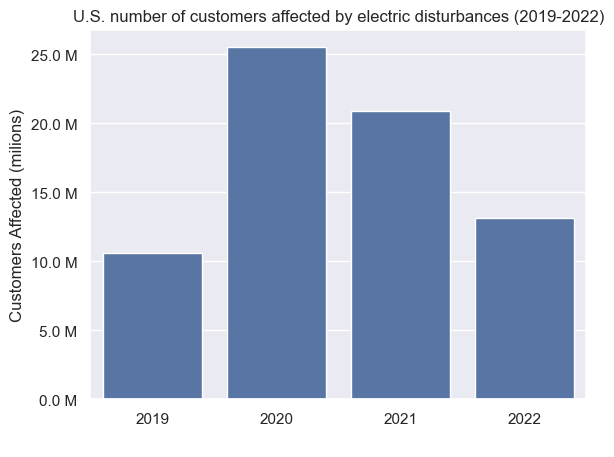

In [111]:
# creating a subset with the columns of interest
df_affect_cust = df[['Number_of_Customers_Affected','Year']].copy()

#grouping by year and summing the number of customers affected
df_affect_cust = df_affect_cust.groupby('Year', as_index=False)['Number_of_Customers_Affected']\
                                .agg('sum')                               

#plotting
sns.set_theme(style='darkgrid')
ax = sns.barplot(data=df_affect_cust, x='Year', y='Number_of_Customers_Affected', color='b')       
ax.set(ylabel='Customers Affected (milions)')
ax.set(title='U.S. number of customers affected by electric disturbances (2019-2022)')

# changing the x_labels values 
ylabels = ['{:,.1f}'.format(x) + ' M' for x in ax.get_yticks()/(1_000_000)]
ax.set_yticklabels(ylabels)

ax.set_xlabel(' ')

plt.show()                                

### What is the mean/median time of restoration by each event type?

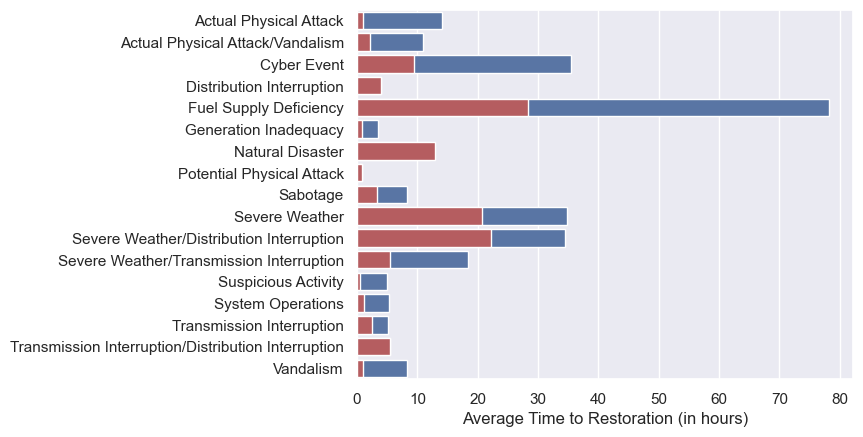

In [112]:
#df_restor_evnt_type = df[['Event_Type','Event_Duration_(hours)']].copy()

df_restor_mean = df[['Event_Type','Event_Duration_(hours)']].groupby('Event_Type', as_index=False)['Event_Duration_(hours)']\
                                                            .agg('mean')                                                     

df_restor_median = df[['Event_Type','Event_Duration_(hours)']].groupby('Event_Type', as_index=False)['Event_Duration_(hours)']\
                                                              .agg('median')                                                             

sns.set_theme(style='darkgrid')
sns.barplot(data=df_restor_mean, x='Event_Duration_(hours)', y='Event_Type', color='b')
ax = sns.barplot(data=df_restor_median, x='Event_Duration_(hours)', y='Event_Type', color='r')
ax.set(ylabel='',xlabel='Average Time to Restoration (in hours)')

plt.show()

In [30]:
type_event_restor = events_data[['Event Type','Event Duration (hours)']].copy()

# dataframe with all the types of events
total_events_type = events_data['Event Type'].unique()
total_events_type = pd.DataFrame(total_events_type)

# Funtion to search the expression '/'
def str_search(string, expres):
    return expres in str(string)

# searching the '/' in all the lines 
events_type_mask = total_events_type.applymap(lambda x: str_search(x, '/'))

# saving only the unique type of events
unique_events = total_events_type[~events_type_mask].dropna().copy()
unique_events = list(unique_events.iloc[:,0])

avg_time_list = []

for i in range(len(unique_events)):
    pattern = unique_events[i]
    mask = type_event_restor['Event Type'].str.contains(pattern)
    avg_time = type_event_restor.loc[mask,'Event Duration (hours)'].mean()
    avg_time_list.append(round(avg_time,2))

df_type_event_restor = pd.DataFrame({'Event_Type':unique_events, 'Avg_Time_Restoration_(hours)':avg_time_list})
df_type_event_restor = df_type_event_restor.sort_values('Avg_Time_Restoration_(hours)', ascending=False)
df_type_event_restor

,Event_Type,Avg_Time_Restoration_(hours)
9,Natural Disaster,12.07
1,Severe Weather,9.23
8,Distribution Interruption,8.63
6,Fuel Supply Deficiency,6.28
12,Cyber Event,5.93
3,Actual Physical Attack,4.56
5,Transmission Interruption,4.56
7,Generation Inadequacy,3.40
0,System Operations,3.14
4,Vandalism,2.89


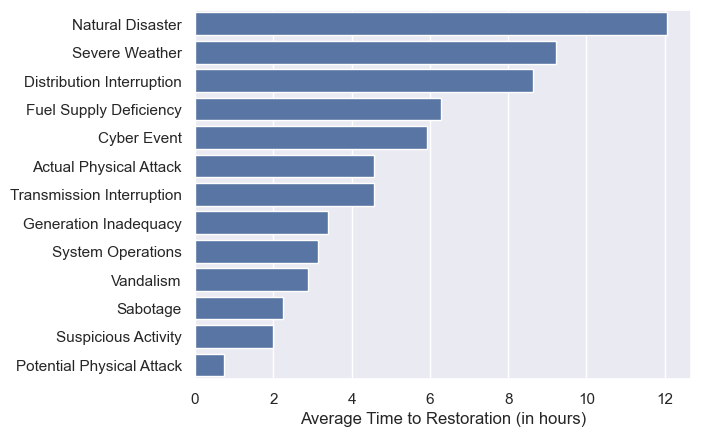

In [35]:
#plt.subplots(figsize=(6,5))
sns.set_theme(style='darkgrid')
ax = sns.barplot(data=df_type_event_restor, x='Avg_Time_Restoration_(hours)', y='Event_Type', color='b')
ax.set(ylabel='',xlabel='Average Time to Restoration (in hours)')
plt.show()
